In [1]:
%cd ~/bench

/home/soda/rcappuzz/work/benchmark-join-suggestions


In [2]:
%load_ext autoreload
%autoreload 2
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import matplotlib.colors as mcolors
import src.utils.plotting as plotting
from src.utils.logging import read_logs
from matplotlib.gridspec import GridSpec
import polars.selectors as cs

import tarfile
import json
import pandas as pd 
cfg = pl.Config()
cfg.set_fmt_str_lengths(150)

polars.config.Config

In [3]:
exp_name = (
    "0332-92xkckqk"
)
df_raw = read_logs(exp_name=exp_name, exp_path=None)

In [4]:
df_raw=df_raw.with_columns(
    cs.contains("time_join").fill_null(0)
)

In [5]:
df_raw.columns

['scenario_id',
 'status',
 'target_dl',
 'jd_method',
 'base_table',
 'query_column',
 'estimator',
 'aggregation',
 'chosen_model',
 'fold_id',
 'time_fit',
 'time_predict',
 'time_run',
 'time_prepare',
 'time_model_train',
 'time_join_train',
 'time_model_predict',
 'time_join_predict',
 'peak_fit',
 'peak_predict',
 'peak_test',
 'r2score',
 'rmse',
 'f1score',
 'auc',
 'n_cols',
 'budget_type',
 'budget_amount',
 'epsilon']

In [40]:
chosen_model = "catboost"
results = df_raw.filter(pl.col("chosen_model") == chosen_model).group_by("estimator").agg(
    # pl.col("time_fit").mean(),
    # pl.col("time_predict").mean(),
    # pl.col("time_run").mean(),
    pl.col("time_prepare").mean(),
    pl.col("time_model_train").mean(),
    pl.col("time_join_train").mean(),
    pl.col("time_model_predict").mean(),
    pl.col("time_join_predict").mean(),
).melt(id_vars="estimator")

In [41]:
results

estimator,variable,value
str,str,f64
"""stepwise_greedy_join""","""time_prepare""",19.562097
"""nojoin""","""time_prepare""",0.065456
"""best_single_join""","""time_prepare""",0.045794
"""highest_containment""","""time_prepare""",13.699701
"""full_join""","""time_prepare""",0.063064
"""stepwise_greedy_join""","""time_model_train""",540.671946
"""nojoin""","""time_model_train""",1.42061
"""best_single_join""","""time_model_train""",83.295438
"""highest_containment""","""time_model_train""",7.189362


In [42]:
dicts = results.group_by(
    "estimator"
).agg(pl.all()).to_dicts()

In [43]:
d = dicts[0]

In [44]:
to_concat = []
for _, gr in results.group_by(
    "estimator"
):
    new_g = gr.sort("variable").with_columns(
        pl.col("value").cumsum().alias("csum")
    ).with_columns(
        pl.col("csum").alias("bottom").shift(1).fill_null(0),
    )
    to_concat.append(new_g)
df_c = pl.concat(to_concat)

In [45]:
new_g

estimator,variable,value,csum,bottom
str,str,f64,f64,f64
"""stepwise_greedy_join""","""time_join_predict""",44.887169,44.887169,0.0
"""stepwise_greedy_join""","""time_join_train""",288.094738,332.981907,44.887169
"""stepwise_greedy_join""","""time_model_predict""",0.0624,333.044307,332.981907
"""stepwise_greedy_join""","""time_model_train""",540.671946,873.716253,333.044307
"""stepwise_greedy_join""","""time_prepare""",19.562097,893.278349,873.716253


In [46]:
dicts = df_c.group_by("variable").agg(pl.all()).sort("variable").to_dicts()

In [47]:
df_c.group_by("variable").agg(pl.all()).sort("variable")

variable,estimator,value,csum,bottom
str,list[str],list[f64],list[f64],list[f64]
"""time_join_predict""","[""nojoin"", ""best_single_join"", … ""stepwise_greedy_join""]","[0.0, 50.314468, … 44.887169]","[0.0, 50.314468, … 44.887169]","[0.0, 0.0, … 0.0]"
"""time_join_train""","[""nojoin"", ""best_single_join"", … ""stepwise_greedy_join""]","[0.0, 722.143547, … 288.094738]","[0.0, 772.458015, … 332.981907]","[0.0, 50.314468, … 44.887169]"
"""time_model_predict""","[""nojoin"", ""best_single_join"", … ""stepwise_greedy_join""]","[0.112269, 0.139617, … 0.0624]","[0.112269, 772.597633, … 333.044307]","[0.0, 772.458015, … 332.981907]"
"""time_model_train""","[""nojoin"", ""best_single_join"", … ""stepwise_greedy_join""]","[1.42061, 83.295438, … 540.671946]","[1.532879, 855.893071, … 873.716253]","[0.112269, 772.597633, … 333.044307]"
"""time_prepare""","[""nojoin"", ""best_single_join"", … ""stepwise_greedy_join""]","[0.065456, 0.045794, … 19.562097]","[1.598335, 855.938864, … 893.278349]","[1.532879, 855.893071, … 873.716253]"


time_join_predict
[0.0, 50.31446783809524, 311.6546859333334, 41.41888125714286, 44.88716895238095]
time_join_train
[0.0, 772.4580151428573, 935.3299812857144, 123.60685917619047, 332.98190692857133]
time_model_predict
[0.11226911904761905, 772.5976325952383, 935.7350218142859, 123.74167575714284, 333.0443069238094]
time_model_train
[1.532879238095238, 855.8930706047621, 958.8191699142859, 130.93103729047618, 873.7162525952381]
time_prepare
[1.5983351714285714, 855.9388643142859, 958.8822342238097, 144.63073804761905, 893.2783493523809]


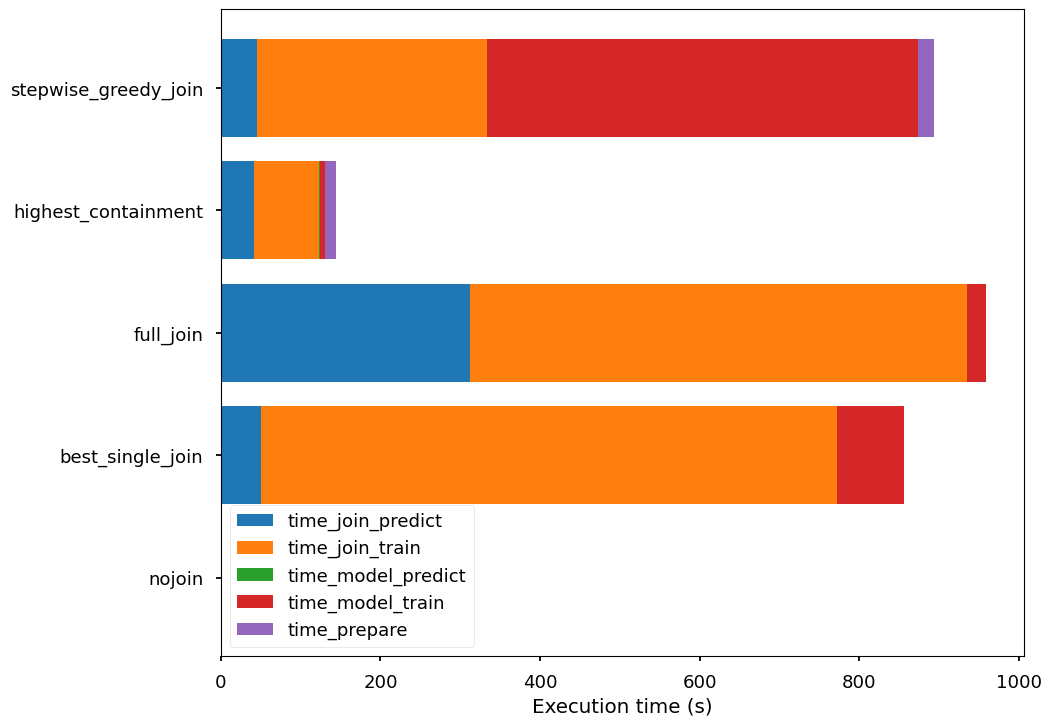

In [48]:
fig, axs = plt.subplots(squeeze=True, layout="constrained")
for idx, d in enumerate(dicts):
    print(d["variable"])
    print(d["csum"])
    p = axs.barh(y=d["estimator"], width = d["value"], left=d["bottom"], label=d["variable"])
    # axs.bar_label(p,)
axs.legend()
axs.set_xlabel("Execution time (s)")
fig.savefig(f"images/time_spent_{chosen_model}.png")

# Memory footprint

In [57]:
df_mem = df_raw.select(
    pl.col("estimator"),
    pl.col("chosen_model"),
    pl.col("peak_fit"),
    pl.col("peak_predict"),
    pl.col("peak_test"),
).melt(id_vars=["estimator", "chosen_model"])

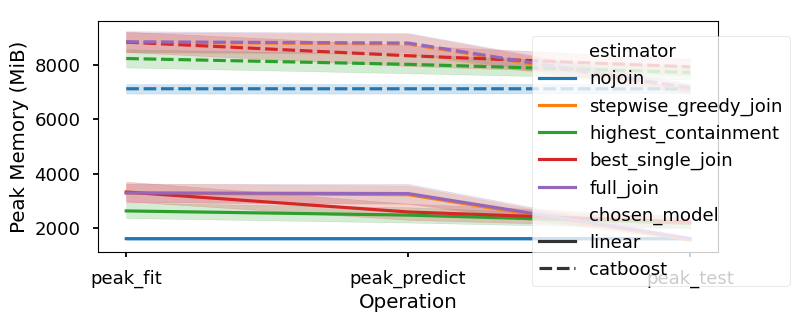

In [72]:
fig, ax = plt.subplots(figsize=(8,3))
ax = sns.lineplot(data=df_mem, x="variable", y="value", hue="estimator", style="chosen_model", legend="brief")
ax.set_ylabel("Peak Memory (MiB)")
ax.set_xlabel("Operation")
h,l = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(h, l, 
           loc="outside right"
           )
fig.savefig("images/peak_memory.png")